In [16]:
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np





In [17]:
df = pd.read_csv('data.csv')
df.head()

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,01/07/2019,"15,987","9,962",407,"21,223","3,715",NaN
1,30/08/2024,"16,436","10,705",225,"19,026","3,925",59
2,15/09/2023,"15,499","10,671",267,"18,421","4,519",61
3,28/12/2021,"1,756","2,352",0,"3,775",0,13
4,11/01/2023,"10,536","8,347",223,"14,072",0,48


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1918 non-null   object
 1   Local Route   1918 non-null   object
 2   Light Rail    1918 non-null   object
 3   Peak Service  1918 non-null   object
 4   Rapid Route   1918 non-null   object
 5   School        1918 non-null   object
 6   Other         1916 non-null   object
dtypes: object(7)
memory usage: 105.0+ KB


In [19]:
df.isna().sum()

Date            0
Local Route     0
Light Rail      0
Peak Service    0
Rapid Route     0
School          0
Other           2
dtype: int64

In [20]:
df.dtypes

Date            object
Local Route     object
Light Rail      object
Peak Service    object
Rapid Route     object
School          object
Other           object
dtype: object

In [21]:
df['Date'] = pd.to_datetime(df['Date'], format= "%d/%m/%Y")
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.replace(",", "").astype(int, errors= 'ignore')
    

In [22]:
df.dtypes

Date            datetime64[ns]
Local Route              int32
Light Rail               int32
Peak Service             int32
Rapid Route              int32
School                   int32
Other                   object
dtype: object

In [23]:
df_other = df
df_other.sort_values(['Date'],inplace=True)
df_otherm = df_other.set_index('Date')
df_otherm.fillna(0,inplace=True)
df_otherm.isna().sum()

Local Route     0
Light Rail      0
Peak Service    0
Rapid Route     0
School          0
Other           0
dtype: int64

In [24]:
for col in df_otherm.select_dtypes(include='object').columns:
    df_otherm[col] = df_otherm[col].str.replace(",", "").astype(int, errors= 'ignore')
    if col == 'Other':
         df_otherm[col] =  pd.to_numeric(df_otherm[col],  errors='coerce').astype('Int32')
         df_otherm.fillna(0,inplace=True)
         df_otherm[col] =  pd.to_numeric(df_otherm[col],  errors='coerce').astype('int32')


df_otherm.sort_index(axis=1,inplace=True)
print(df_otherm.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1918 entries, 2019-07-01 to 2024-09-29
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Light Rail    1918 non-null   int32
 1   Local Route   1918 non-null   int32
 2   Other         1918 non-null   int32
 3   Peak Service  1918 non-null   int32
 4   Rapid Route   1918 non-null   int32
 5   School        1918 non-null   int32
dtypes: int32(6)
memory usage: 59.9 KB
None


In [25]:
df.drop('Other',axis=1,inplace=True)

In [26]:
df.sort_values(['Date'],inplace=True)
dfm = df.set_index('Date')
df_month = dfm.resample('M').agg({
    'Local Route': 'sum','Light Rail': 'sum','Peak Service': 'sum','Rapid Route': 'sum','School' : 'sum' 
})
df_month.sort_index(inplace=True)

In [27]:
df_month.head(10)

,Local Route,Light Rail,Peak Service,Rapid Route,School
Date,,,,,
2019-07-31,406607,292641,9520,555002,63773
2019-08-31,456797,316416,9519,623134,119419
2019-09-30,424399,305334,9204,584540,111689
2019-10-31,407732,320310,9139,613572,79456
2019-11-30,413213,301518,9081,580930,114722
2019-12-31,309112,245827,6382,439883,42891
2020-01-31,267256,234612,6630,417537,0
2020-02-29,428890,307455,9160,599212,126842
2020-03-31,315514,209701,6804,443968,86227


In [28]:
df_otherm.tail(30)['School']

Date
2024-08-31       0
2024-09-01       0
2024-09-02    4967
2024-09-03    4826
2024-09-04    4528
2024-09-05    4713
2024-09-06    4621
2024-09-07       0
2024-09-08       0
2024-09-09    4797
2024-09-10    4629
2024-09-11    4750
2024-09-12    4627
2024-09-13    4378
2024-09-14       0
2024-09-15       0
2024-09-16    4726
2024-09-17    4878
2024-09-18    4401
2024-09-19    4557
2024-09-20      37
2024-09-21       0
2024-09-22       0
2024-09-23      10
2024-09-24       3
2024-09-25       8
2024-09-26       2
2024-09-27       0
2024-09-28       0
2024-09-29       0
Name: School, dtype: int32

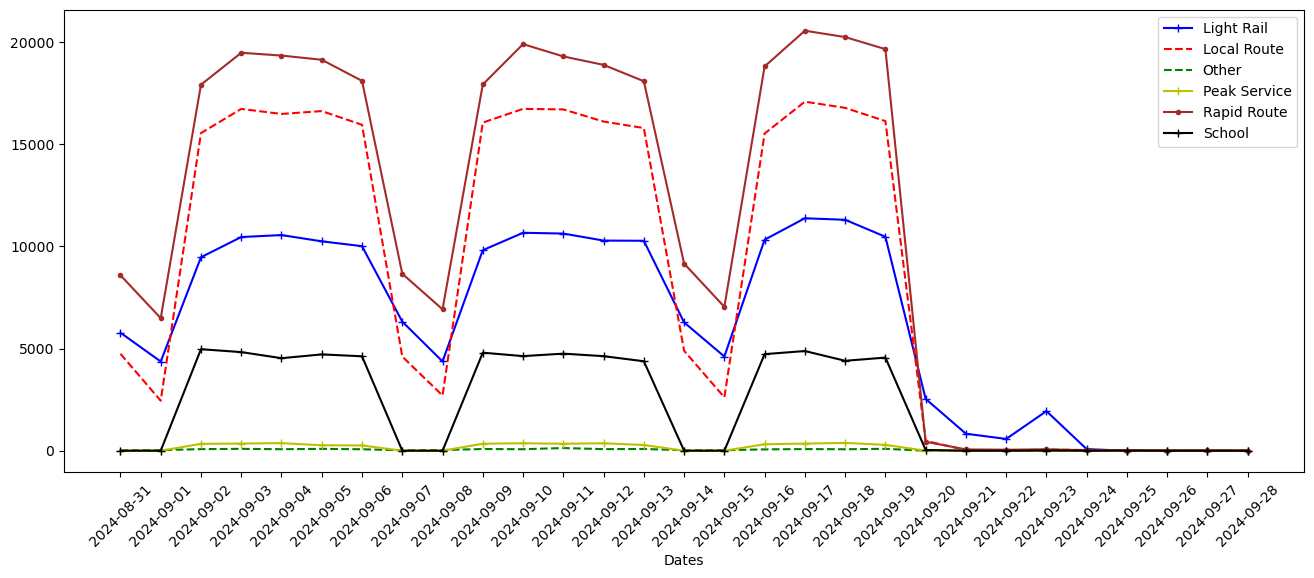

In [29]:


start, end = -30,-1
series = df_otherm.iloc[start:end,0]
X = series.index
Y1 = series.values
Y2= df_otherm.iloc[start:end,1].values
Y3 = df_otherm.iloc[start:end,2].values
Y4 = df_otherm.iloc[start:end,3].values
Y5 = df_otherm.iloc[start:end,4].values
Y6 = df_otherm.iloc[start:end,5].values

plt.figure(figsize=(16, 6))

plt.plot(X,Y1,color='b', label=f'{df_otherm.columns[0]}', marker='+')
plt.plot(X,Y2,'r--', label=f'{df_otherm.columns[1]}')
plt.plot(X,Y3,'g--', label=f'{df_otherm.columns[2]}')
plt.plot(X,Y4,'y+-', label=f'{df_otherm.columns[3]}')
plt.plot(X,Y5,color='brown', label=f'{df_otherm.columns[4]}', marker='.')
plt.plot(X,Y6,color='black', label=f'{df_otherm.columns[5]}', marker='+')

plt.xlabel("Dates")
plt.xticks(X,rotation=45) 
plt.legend()


In [30]:
df.iloc[:,1].values
next_7_days = pd.date_range(start=dfm.index[-1] + pd.Timedelta(days=1), periods=7, freq='M')
next_7_Month = pd.to_datetime(next_7_days,format= "%d/%m/%Y")
print(next_7_Month)

df.iloc[:,1].values
next_7_days = pd.date_range(start=dfm.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
next_7_days = pd.to_datetime(next_7_days,format= "%d/%m/%Y")
next_7_days = next_7_days[:]
print(next_7_days)


DatetimeIndex(['2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31',
               '2025-01-31', '2025-02-28', '2025-03-31'],
              dtype='datetime64[ns]', freq='M')
DatetimeIndex(['2024-09-30', '2024-10-01', '2024-10-02', '2024-10-03',
               '2024-10-04', '2024-10-05', '2024-10-06'],
              dtype='datetime64[ns]', freq='D')


Light Rail


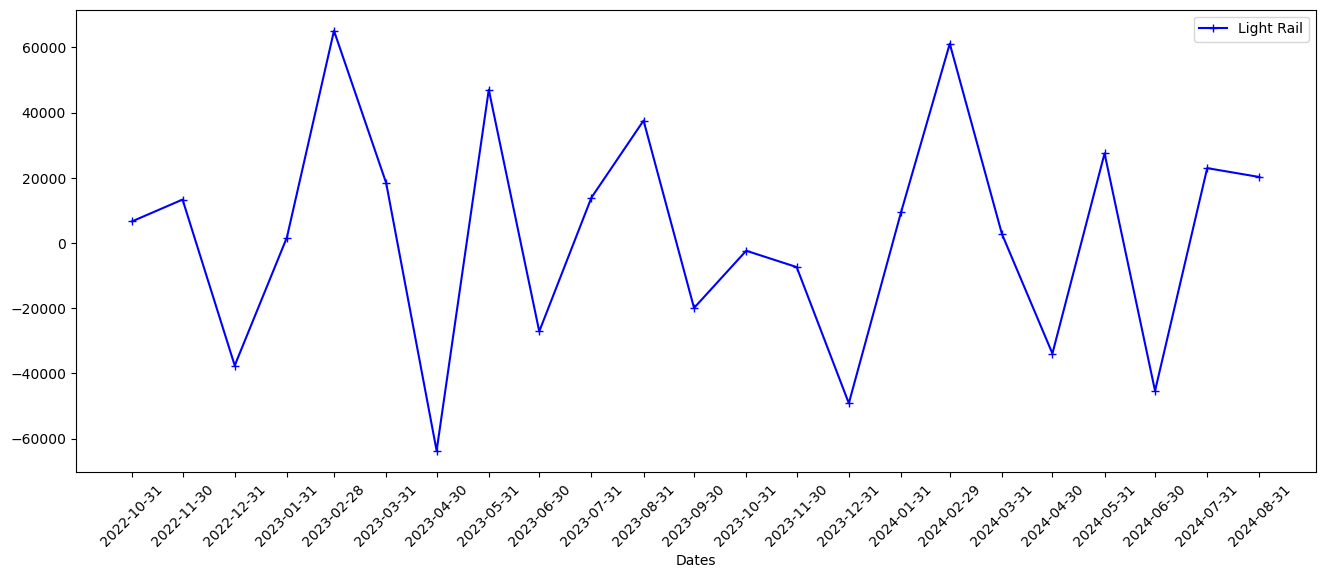

In [31]:
diff1 = df_month.diff()[1:]
start, end = -24,-1
print(diff1.columns[1])

column = 1
series = diff1.iloc[start:end,column]

X = series.index
Y1 = series.values



plt.figure(figsize=(16, 6))
plt.plot(X,Y1,color='b', label=f'{diff1.columns[column]}', marker='+')
plt.xlabel("Dates")
plt.xticks(X,rotation=45) 
plt.legend()

Light Rail


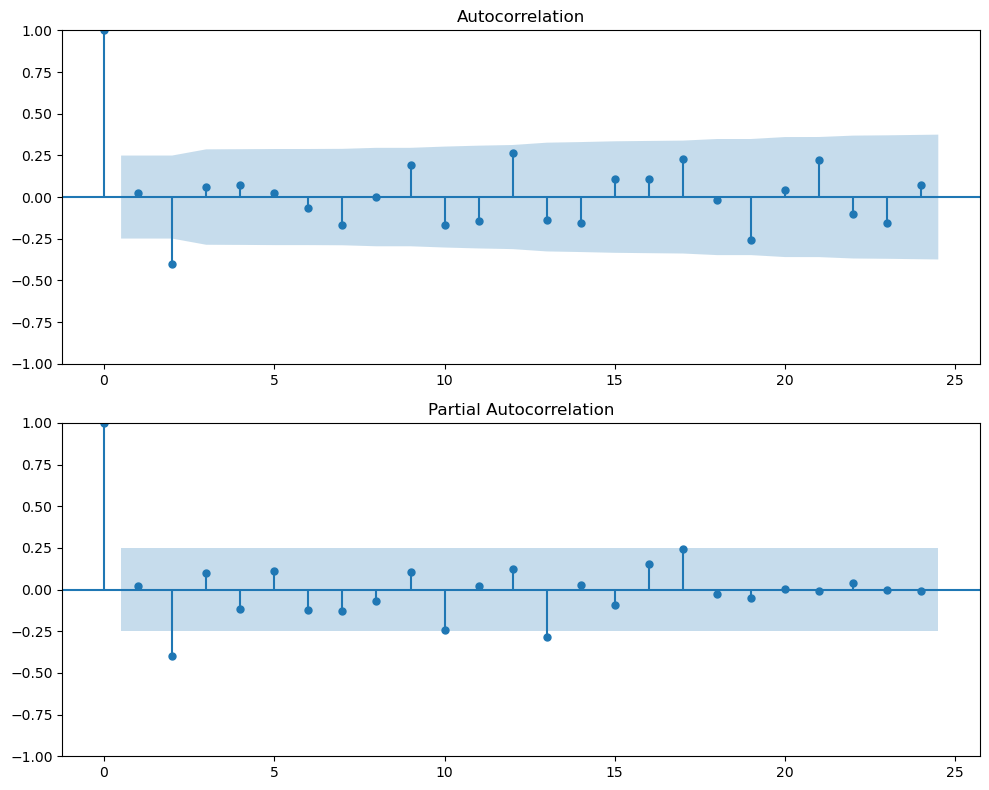

Light Rail


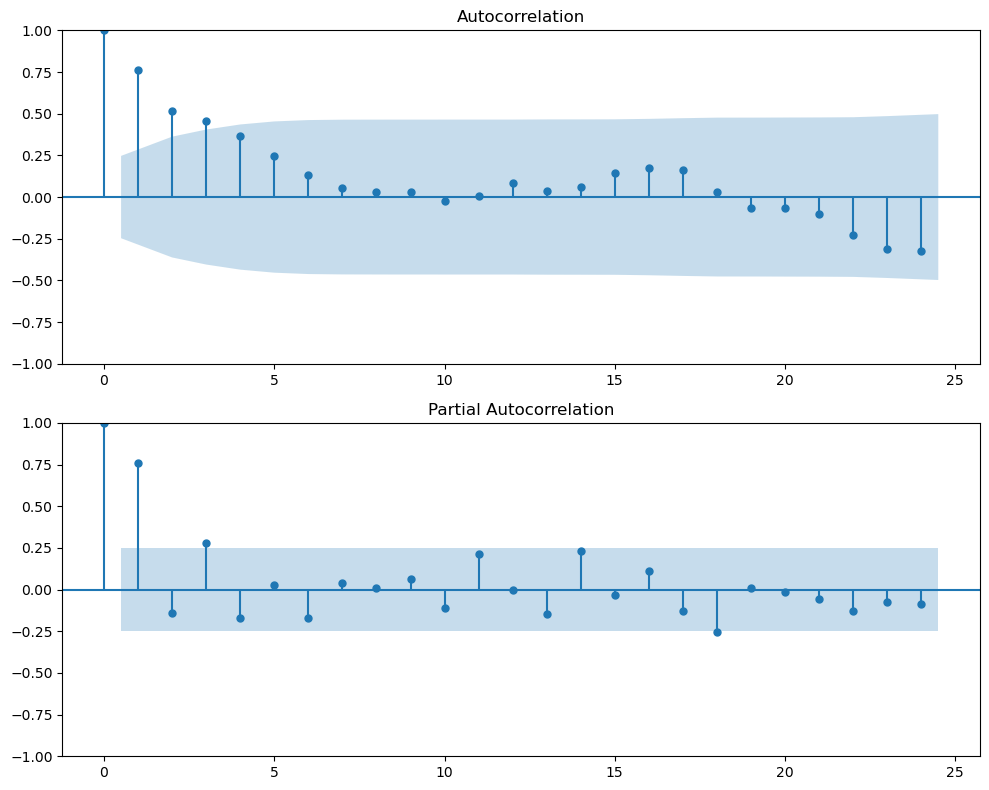

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf


fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff1[diff1.columns[1]], lags=24, ax=ax[0])
plot_pacf(diff1[diff1.columns[1]], lags=24, ax=ax[1])
print(diff1.columns[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_month[df_month.columns[1]], lags=24, ax=ax[0])
plot_pacf(df_month[df_month.columns[1]], lags=24, ax=ax[1])
print(df_month.columns[1])
plt.tight_layout()
plt.show()



Light Rail


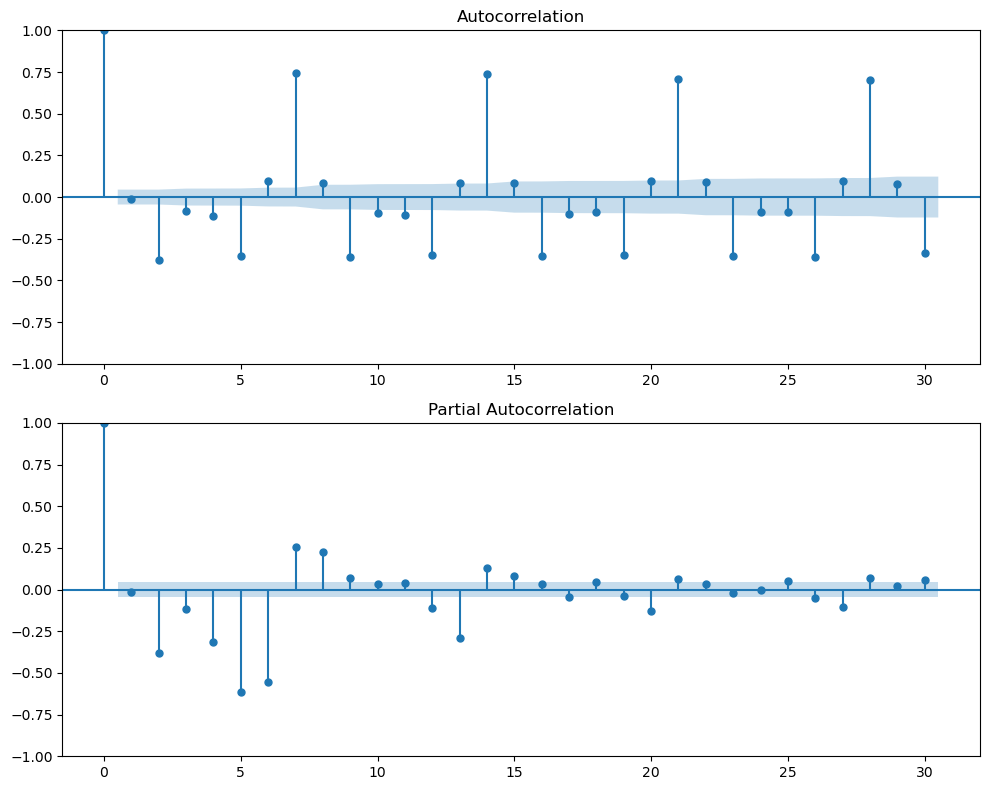

Light Rail


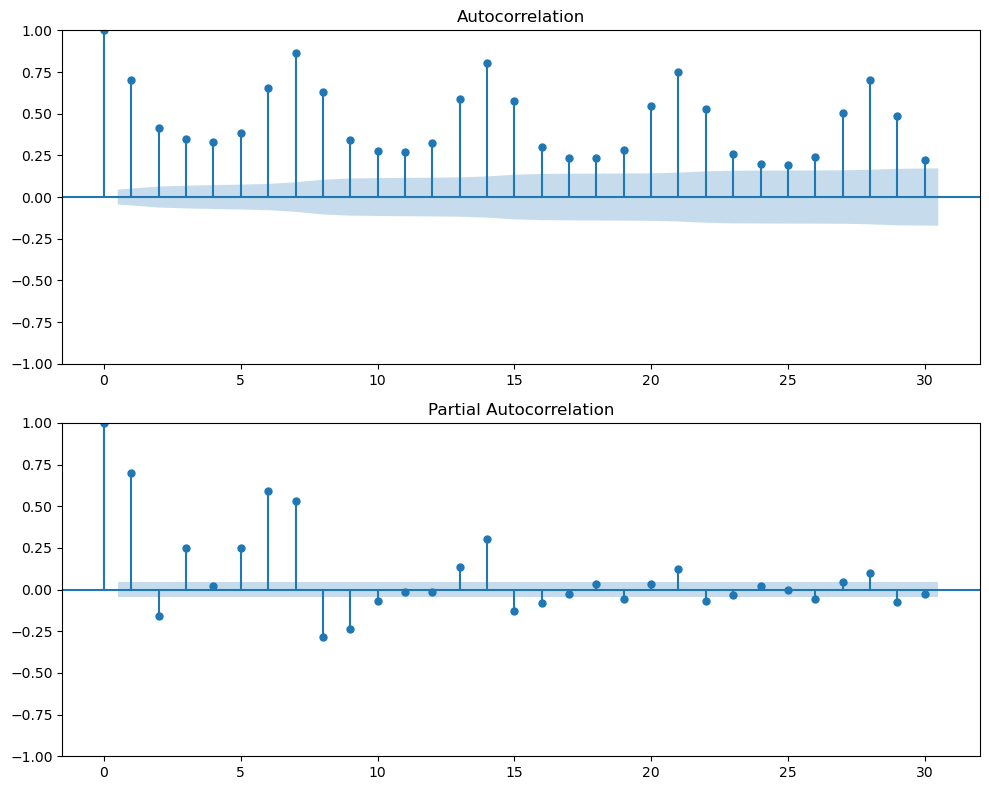

In [33]:
diff1 = dfm.diff()[1:]
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff1[diff1.columns[1]], lags=30, ax=ax[0])
plot_pacf(diff1[diff1.columns[1]], lags=30, ax=ax[1])
print(diff1.columns[1])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(dfm[dfm.columns[1]], lags=30, ax=ax[0])
plot_pacf(dfm[dfm.columns[1]], lags=30, ax=ax[1])
print(dfm.columns[1])
plt.tight_layout()
plt.show()

In [34]:
df_t = dfm
def calculate_mape(actual, forecast):
    return (abs((actual - forecast) /( (actual + forecast)/2)).mean()) * 100

def calculate_RMSE(actual, forecast):

    a = np.sqrt(np.mean((actual - forecast) ** 2))

    return a

def calculate_error(df,col_names):
    error_df = df[df['School'] > -1]
    
    error_forecast = calculate_RMSE(error_df.iloc[:,col_names],error_df['Forecast'])
    error_blended = calculate_RMSE(error_df.iloc[:,col_names],error_df['Blended'])
    return error_forecast, error_blended


def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

In [35]:
df_train,df_test = df.iloc[:-4,:], df.iloc[-4:-1,:]
df_test.tail()

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School
1330,2024-09-26,9,0,0,0,2
1731,2024-09-27,6,0,0,13,0
1652,2024-09-28,1,0,0,4,0


In [36]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing


def ARIMA_Model(df,p,d,q, col_names,n_forecast,next_7_days):
    df_train,df_test = df.iloc[:-3,:], df.iloc[-3:,:]
    
    model = ARIMA(df_train[col_names],order=(p,d,q))
    model_fit = model.fit()

    arima_forecast = model_fit.forecast(steps=n_forecast +3)

    result = {
        'Date' : next_7_days,
        f'Forecast' : 0
    }

    result = pd.DataFrame(result).set_index('Date')
    dates = pd.concat([df_test, result], axis=1)
    
    dates['Forecast'] = arima_forecast

    return dates

def Auto_ARIMA(df,flag,days,col,n_forecast):

    df_train,df_test = df.iloc[:-3,:], df.iloc[-3:,:]

    if flag == 'S':
        model = pm.auto_arima(df_train[col], seasonal=True, m=7, stepwise=True, trace=True)
    else:
        model = pm.auto_arima(df_train[col], seasonal=False, stepwise=True, trace=True)

    forecast, conf_int = model.predict(n_periods=n_forecast +3, return_conf_int=True)
    result = {
        'Date' : days,
        f'Forecast' : 0
    }
    print(len(forecast))
    result = pd.DataFrame(result).set_index('Date')
    df_test['Forecast'] = forecast[:3]
    print(df_test,result)

    dates = pd.concat([df_test, result])
    dates['Forecast'] = forecast

    print(dates)

    
    return dates

def SARIMA_Model(df,sp , mp, col_names,n_forecast,days):

    df_train,df_test = df.iloc[:-3,:], df.iloc[-3:,:]
    sarima_model = SARIMAX(df_train[col_names], order= sp, seasonal_order= mp)
    sarima_fit = sarima_model.fit(disp=False)
    

    Sarima_forecast = sarima_fit.forecast(steps=n_forecast +3)
    
    
    result = {
        'Date' : days,
        f'Forecast' : 0
    }
    result = pd.DataFrame(result).set_index('Date')
    df_test['Forecast'] = Sarima_forecast[0:3]
    print(df_test,result)
    
    
    dates = pd.concat([df_test, result])
    print(dates)
    
    dates['Forecast'] = Sarima_forecast

    return dates

def ES(df, col_names,n_forecast,next_7_days, flag = 'DES'):

    df_train,df_test = df.iloc[:-3,:], df.iloc[-3:,:]
    if flag == 'TES':
        model = ExponentialSmoothing(df_train[col_names], trend='add', seasonal='add', seasonal_periods=7)
    else:
        model = ExponentialSmoothing(df_train[col_names], trend='add', seasonal=None)

    fit_model = model.fit()
 

    forecast = fit_model.forecast(steps=n_forecast +3)

    result = {
        'Date' : next_7_days,
        f'Forecast' : 0
    }
    

    result = pd.DataFrame(result).set_index('Date')
    df_test['Forecast'] = forecast[:3]


    
    dates = pd.concat([df_test, result])
 
    dates['Forecast'] = forecast
  

    return dates

from prophet import Prophet
def Prophet_model(df, col,period_f): 
    df_p = df.reset_index()
    df_p = df_p.rename(columns={df_p.columns[0]: 'ds', df_p.columns[col+1]: 'y'}) 

    df_p = df_p[['ds','y']]
    dp_pa = df_p

    df_p = df_p.iloc[:,:]

    model = Prophet(interval_width=0.9,yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(df_p)

    future = model.make_future_dataframe(periods=10,include_history=True,freq = 'D',)
    forecast = model.predict(future)
    

    return model ,forecast , df_p, dp_pa, forecast

def Seasonal_naive(df,col,next_7_days,fperiod):
    import numpy as np

    season_length = 7
    train = df.iloc[:-3,:]
    df_test = df.iloc[-3:,:]

    forecast = np.tile(train.iloc[-7:,col].values, round(fperiod/2) +1)
    result = {
        'Date' : next_7_days,
        f'Forecast' : 0
    }

    result = pd.DataFrame(result).set_index('Date')
    df_test['Forecast'] = forecast[:3]

    dates = pd.concat([df_test, result])

    dates['Forecast'] = forecast[:len(dates)]
    return dates





In [37]:
df_without_0 = dfm.iloc[:-10]


next_7_daysw = pd.date_range(start=df_without_0.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
next_7_daysw = pd.to_datetime(next_7_days,format= "%d/%m/%Y")
next_7_daysw = dfm.iloc[-10:-3].index
print(next_7_daysw)

df_without_0.iloc[:,1].values
next_7_days4 = pd.date_range(start=df_without_0.index[-1] + pd.Timedelta(days=1), periods=14, freq='D')
next_7_days4 = pd.to_datetime(next_7_days4,format= "%d/%m/%Y")
next_7_days4 = next_7_days4[:]
print(next_7_days4)

DatetimeIndex(['2024-09-20', '2024-09-21', '2024-09-22', '2024-09-23',
               '2024-09-24', '2024-09-25', '2024-09-26'],
              dtype='datetime64[ns]', name='Date', freq=None)
DatetimeIndex(['2024-09-20', '2024-09-21', '2024-09-22', '2024-09-23',
               '2024-09-24', '2024-09-25', '2024-09-26', '2024-09-27',
               '2024-09-28', '2024-09-29', '2024-09-30', '2024-10-01',
               '2024-10-02', '2024-10-03'],
              dtype='datetime64[ns]', freq='D')


In [38]:
column = 1
algo_flag = 2
model_algo = ['DES','TES','Auto ARIMA', 'Auto SARIMA', 'Seasonal Naive', 'ARIMA' , 'SARIMA' , 'Prophet']
algo_flag -=1

data = df_without_0
print(data.columns)
forecast_day = next_7_days4
n_forecast = 14

print(f'----------{model_algo[algo_flag] , data.columns[column]}--------------')

if model_algo[algo_flag] == 'DES':
    forecast = ES(data,data.columns[column],n_forecast,forecast_day)
    
elif model_algo[algo_flag] == 'TES':
    forecast = ES(data,data.columns[column],n_forecast,forecast_day,flag = 'TES')
        
elif model_algo[algo_flag] == 'Auto ARIMA':
    forecast = Auto_ARIMA(data,'A',forecast_day,data.columns[column],n_forecast)

elif model_algo[algo_flag] == 'Auto SARIMA':
    forecast = Auto_ARIMA(data,'S',forecast_day,data.columns[column],n_forecast)

elif model_algo[algo_flag] == 'Seasonal Naive':
    forecast1 = Seasonal_naive(data,column,forecast_day,n_forecast)
    
elif model_algo[algo_flag] == 'ARIMA':
    forecast = ARIMA_Model(data,1,1,1,data.columns[column],n_forecast,forecast_day)

elif model_algo[algo_flag] == 'SARIMA':
    forecast = SARIMA_Model(data,[0,1,0],[3,0,3,7],data.columns[column],n_forecast,forecast_day)

elif model_algo[algo_flag] == 'Prophet':
    model,forecast,df_p, dp_pa,future = Prophet_model(data,column,n_forecast)

forecast_cp = forecast
forecast1 = Seasonal_naive(data,column,forecast_day,7)
forecast1b = forecast1.drop(['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School','Forecast'], axis=1)

forecast1b = forecast1.drop(['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School','Forecast'], axis=1)    



Index(['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School'], dtype='object')
----------('TES', 'Light Rail')--------------


c:\Users\hariharan.balaji\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hariharan.balaji\Anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hariharan.balaji\AppData\Local\Temp\ipykernel_19724\1034005657.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Forecast'] = forecast[:3]
C:\Users\hariharan.balaji\AppData\Local\Temp\ipykernel_19724\1034005657.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [39]:

a = 0.7

if model_algo[algo_flag] != 'Prophet':
    forecast = forecast_cp
    forecast['Forecast'] = forecast['Forecast'].clip(lower=0)
    forecast1['ForecastB'] = forecast1['Forecast']
    forecast1b = forecast1.drop(['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School','Forecast'], axis=1)
    forecasttt = forecast.merge(forecast1b, left_index=True, right_index=True, how='left')
    forecasttt['Blended'] = (a * forecasttt['Forecast']) + ((1-a) * forecasttt['ForecastB'])
    forecast1 = forecast1.drop(['ForecastB'], axis=1)
    forecast = forecasttt
    
    e1,e2 = calculate_error(forecast,1)
    

    
    print(f'RMSE value of forecast & blended for {data.columns[column]} : ',e1,e2)
    
else:
    temp = forecast[-14:]
    df_pt = temp.merge(forecast1, left_on='ds', right_on= 'Date', how='inner')
    df_pt['yhat'] = df_pt['yhat'].clip(lower=0)
    df_pt['Blended'] = (a * df_pt['yhat']) + ((1-a) * df_pt['Forecast'])
    # e1,e2 = calculate_error(forecast,1)
    # print(f'RMSE value of forecast & blended for {dfm.columns[column]} : ',e1,e2)



RMSE value of forecast & blended for Light Rail :  331.25642041456825 368.53943201811387


Light Rail


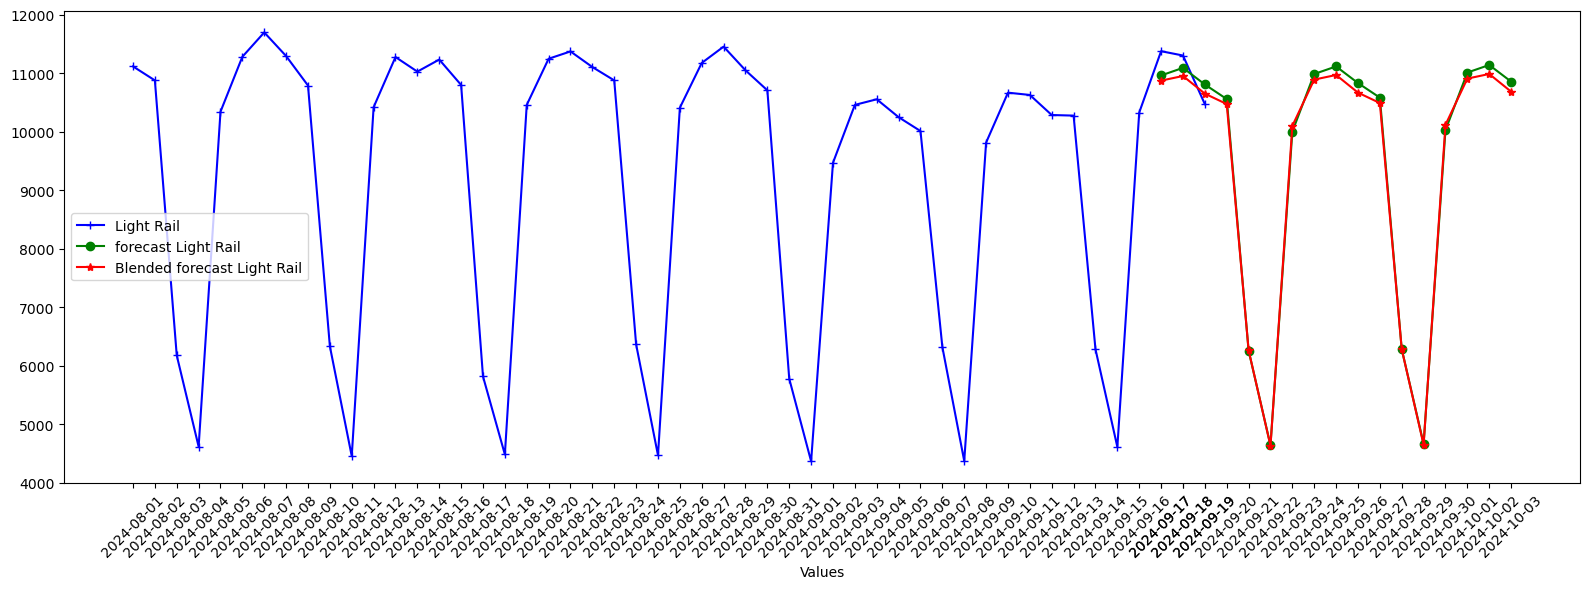

In [40]:
if model_algo[algo_flag] != 'Prophet':
    start, end = -50,0
    print(data.columns[column])

    series = data.iloc[start:,column]
    X = series.index.values
    X2= forecast.index.values
    X3 = np.append(X,X2)

    Y1 = series.values
    Y2 = forecast['Forecast'].values
    Y3 = forecast['Blended'].values


    

    plt.figure(figsize=(16, 6))

    plt.plot(X,Y1,color='b', label=f'{data.columns[column]}', marker='+')
    plt.plot(X2,Y2,color='g', label=f'forecast {data.columns[column]}', marker='o')
    plt.plot(X2,Y3,color='r', label=f'Blended forecast {data.columns[column]}', marker='*')

    plt.xlabel("Values")
    plt.xticks(X3,rotation=45) 
    
    plt.tight_layout() 
    plt.legend()

else:
    t = forecast.iloc[-20:,:]
    
    model.plot(forecast)
    plt.title('Prophet Model Forecast')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.show()
   

    plt.plot(forecast['ds'][-14:], forecast['yhat'][-14:], label='Forecast', marker='o', color='orange')
    plt.plot(dp_pa['ds'][-14:], dp_pa['y'][-14:], label='Actual', marker='o', color='blue')
    
    plt.plot(forecast['ds'][-14:], forecast['yhat'][-14:], label='Forecast', marker='o', color='green')
    # plt.plot(df_pt['ds'][-14:], df_pt['Blended'], label='blended', marker='*', color='black')
    plt.xticks(forecast['ds'][-14:],rotation=45) 
    plt.show()
    model.plot_components(forecast)
    plt.tight_layout() 
    plt.legend()
    plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
dp_pa1 = dp_pa.iloc[-30:,:]

plt.plot(dp_pa1['ds'], dp_pa1['y'],  label='Actual Data')
plt.plot(t['ds'], t['yhat'], 'r--', label='Forecast')

plt.fill_between(t['ds'], t['yhat_lower'], t['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Filtered Forecast using Prophet')

plt.legend()
plt.show()

In [41]:
a = [0,1,2,3,4,5]
# a = [0,1,2,3,4]
datam = df_otherm

for i in a:
    for j in a:
        if i!=j:
            cor = Pearson_correlation(datam.iloc[:,i],datam.iloc[:,j])
            print(f'The correlation between {datam.columns[i]} -> {datam.columns[j]} is {cor:.2f}')

The correlation between Light Rail -> Local Route is 0.92
The correlation between Light Rail -> Other is 0.43
The correlation between Light Rail -> Peak Service is 0.88
The correlation between Light Rail -> Rapid Route is 0.97
The correlation between Light Rail -> School is 0.69
The correlation between Local Route -> Light Rail is 0.92
The correlation between Local Route -> Other is 0.47
The correlation between Local Route -> Peak Service is 0.94
The correlation between Local Route -> Rapid Route is 0.97
The correlation between Local Route -> School is 0.85
The correlation between Other -> Light Rail is 0.43
The correlation between Other -> Local Route is 0.47
The correlation between Other -> Peak Service is 0.38
The correlation between Other -> Rapid Route is 0.38
The correlation between Other -> School is 0.43
The correlation between Peak Service -> Light Rail is 0.88
The correlation between Peak Service -> Local Route is 0.94
The correlation between Peak Service -> Other is 0.38
The

In [42]:

a = [0,1,2,3,4,5]
for i in a:
    mean = df_otherm[df_otherm.columns[i]].values.mean()
    std = df_otherm[df_otherm.columns[i]].values.std()

    cv = std / mean
    print(f'{df_otherm.columns[i]} CV: {cv:.2f}')

Light Rail CV: 0.46
Local Route CV: 0.62
Other CV: 0.97
Peak Service CV: 0.87
Rapid Route CV: 0.53
School CV: 1.06
